In [1]:
import sys
import numpy as np

sys.path.append('..')

from seismicpro.src import seismic_plot, FieldIndex, SeismicDataset, CustomIndex, TraceIndex
from seismicpro.src.plot_utils import semblance_plot
from seismicpro.src.seismic_metrics import PickingMetrics, SemblanceMetrics, MetricsMap

from seismicpro.batchflow import B, V
from seismicpro.batchflow.models.torch import UNet

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


Loading the data and CDP index creation

In [3]:
supergather_path = '/data/H2_PAL/SEMB/H2_PAL_CDP_10x10_SG7.sgy'
part_path = '/data/H2_PAL/SEMB/H2_PAL_CDP.sgy'
full_path = '/data/H2_PAL/SEMB/H2_PAL_SR-lines.sgy'

path_to_model = '../models/trained_model.dill'

supergather_index = FieldIndex(name='raw', extra_headers=['offset', 'CDP_X', 'CDP_Y', 'SourceX', 'SourceY'], path=supergather_path)
supergather_index_cdp = CustomIndex(supergather_index, index_name='CDP')

Prediction by picking model

In [4]:
picking_output_path = './picking_result.csv'
supergather_traces = TraceIndex(supergather_index_cdp)

ds_for_picking = SeismicDataset(supergather_traces)

config = {
    'build': False,
    'device': 'gpu:0',
    'load/path':  path_to_model
}

In [ ]:
picking_pipeline = (
    ds_for_picking.p
    .init_model('static', UNet, 'picking_model', config=config) 
    .load(components='raw', fmt='segy')
    .standardize(src='raw', dst='raw')
    .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
    .add_components(components='predictions')
    .predict_model('picking_model', B('raw'), fetches='predictions',
                   save_to=B('predictions', mode='a'))
    .mask_to_pick(src='predictions', dst='predictions', labels=False)
    .dump(src='predictions', fmt='picks', path=picking_output_path, src_traces='raw',
          input_units='samples')
    .run_later(100, n_epochs=1, drop_last=False, shuffle=False, bar=True)
)

picking_pipeline.run()

Plot unsupervised metrics for picking model

In [5]:
sup_pick_ix = FieldIndex(name='raw', path=supergather_path, markup_path=picking_output_path, extra_headers=('offset', 'CDP_X', 'CDP_Y'))

picking_index = CustomIndex(sup_pick_ix, index_name='CDP')
picked_dataset = SeismicDataset(picking_index)

In [6]:
cv = 0.1
pipeline = (picked_dataset.p
         .add_namespace(PickingMetrics)
         .init_variable('metrics')
         .some_action(src=B('src'), dst=B.dst)
         .load(fmt='segy', components=('raw'))
         .load(fmt='picks', components='markup')
         .load(fmt='index', components='offset', src='offset')
         .sort_traces(src=('raw', 'markup'), dst=('raw', 'markup'), sort_by='offset')
         .velocity(B(), src_picking='markup', dst='diff')
         .get_coords_fm_supergather(src=['CDP_X', 'CDP_Y'], dst='coords')
         .gather_metrics(MetricsMap, metrics=B('diff'),
                         coords=B('coords'),
                         save_to=V('metrics', mode='a'))
         .run_later(1, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

pipeline.run()

  0%|          | 0/43 [00:00<?, ?it/s]../seismicpro/src/seismic_metrics.py:47: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  time = time[mask]
../seismicpro/src/seismic_metrics.py:48: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  offset = offset[mask]
100%|██████████| 43/43 [00:06<00:00,  6.97it/s]


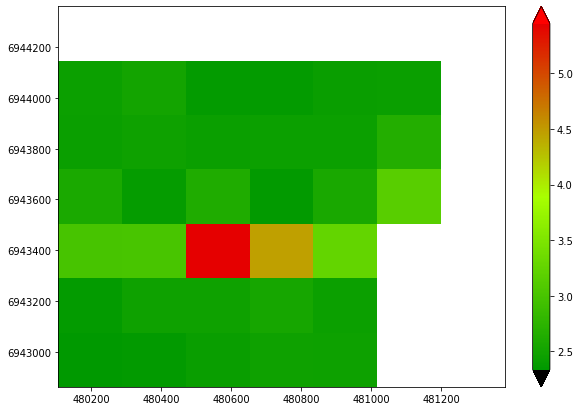

Mean value of metrics: 2.69


In [15]:
metrics_picking = pipeline.v('metrics')
mean_metrics = metrics_picking.evaluate('map', bin_size=250, figsize=(10, 7), save_dir=None, pad=False)
print('Mean value of metrics: {:.3}'.format(mean_metrics))

Based on picking, add muting and finding a speed law for given seismogram

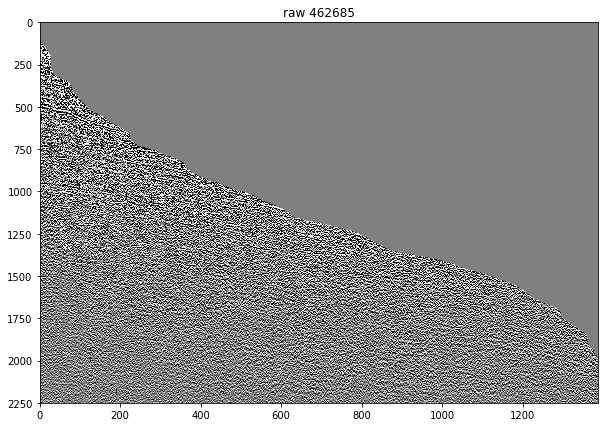

../seismicpro/src/plot_utils.py:573: UserWarning: The following kwargs were not used by contour: 'aplha'
  ax.contour(x_grid, y_grid, semblance, levels, colors='k', linewidths=.7, aplha=.5)


<Figure size 1080x720 with 0 Axes>

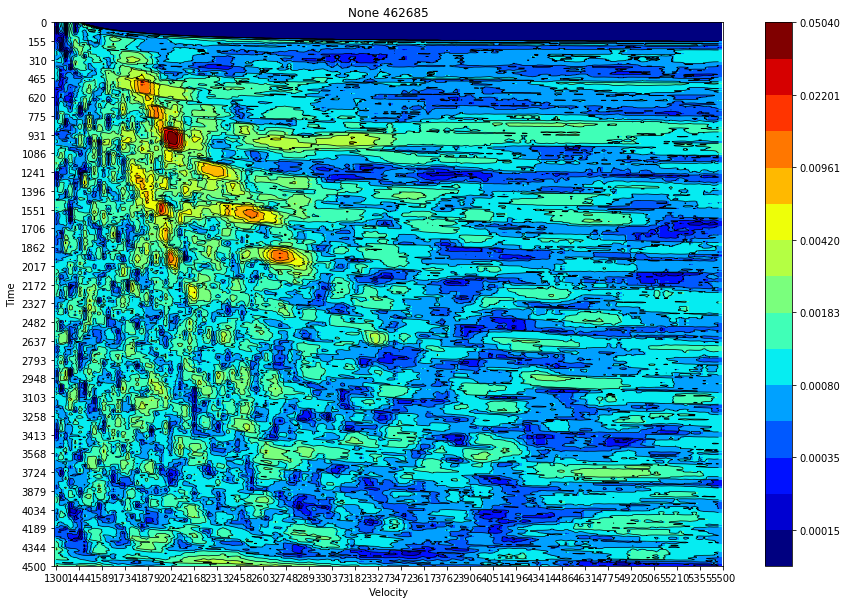

<Figure size 1080x720 with 0 Axes>

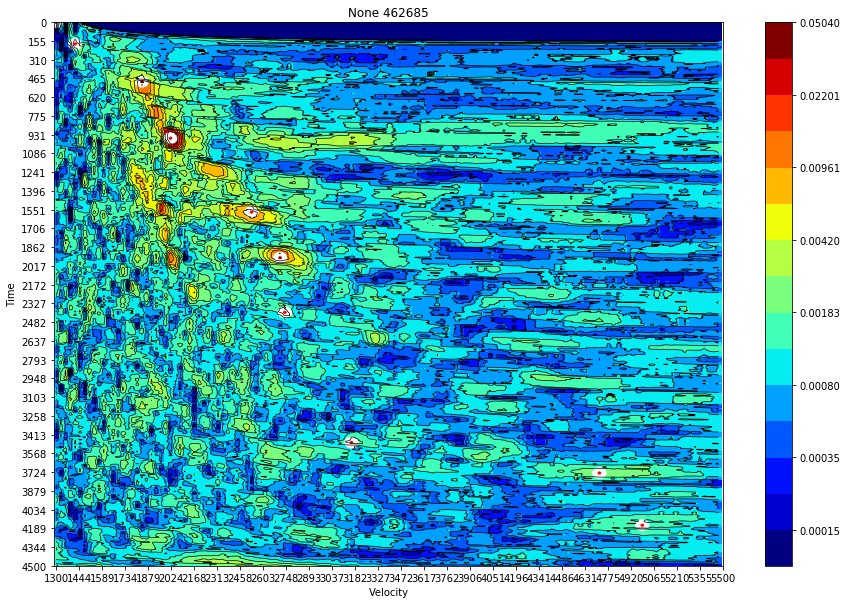

CPU times: user 3min 53s, sys: 1.67 s, total: 3min 54s
Wall time: 3min 36s


In [12]:
%%time

cv = 20
batch = (picked_dataset.next_batch(batch_size=1, shuffle=False))
(batch.load( fmt='segy', components='raw')
      .load(fmt='picks', components='markup')
      .sort_traces(src=('raw', 'markup'), dst=('raw', 'markup'), sort_by='offset')
      .add_muting(src='raw', dst='raw', picking='markup',
                   interp_type='regression', indent=500)
      .seismic_plot(src='raw', index=batch.index.indices[0], figsize=(10, 7), cmap='gray', vmin=-cv, vmax=cv)
      .calculate_semblance(src='raw', dst='raw_semblance', velocities=[1300, 5500],
                           velocities_length=140, window=25)
      .semblance_plot(src='raw_semblance', index=batch.index.indices[0], figsize=(15, 10))
      .find_velocity_model(src='raw_semblance', dst='velocity_points')
)
      
(batch.semblance_plot(src='raw_semblance', index=batch.index.indices[0], figsize=(15, 10), 
                      velocity_points=batch.velocity_points[0]))

In [24]:
from numba import njit, prange
from scipy.interpolate import interp1d

def correct_seismogram(seismogram, points, times, offsets, dt):
    velocities = interpolate_velocities(points, times)
    res = []
    for time, velocity in zip(times, velocities):
        res.append(correct_time(seismogram, time, offsets, velocity, dt))
    return np.stack(res)

@njit(nogil=True, fastmath=True)
def correct_time(seismogram, time, offsets, velocity, dt):
    res = np.zeros(len(offsets))
    corrected_times = (np.sqrt(time**2 + offsets**2/velocity**2) / dt).astype(np.int32)
    for i in range(len(offsets)):
        t = corrected_times[i]
        t = 0 if t < 0 else t
        if t < len(seismogram):
            res[i] = seismogram[t, i]
    return res

def interpolate_velocities(points, times):
    points_times, points_velocities = zip(*points)
    f = interp1d(points_times, points_velocities, fill_value="extrapolate")
    return f(times)

In [25]:
points = np.array([batch.velocity_points[0][:,0]/1000, batch.velocity_points[0][:,1]]).T

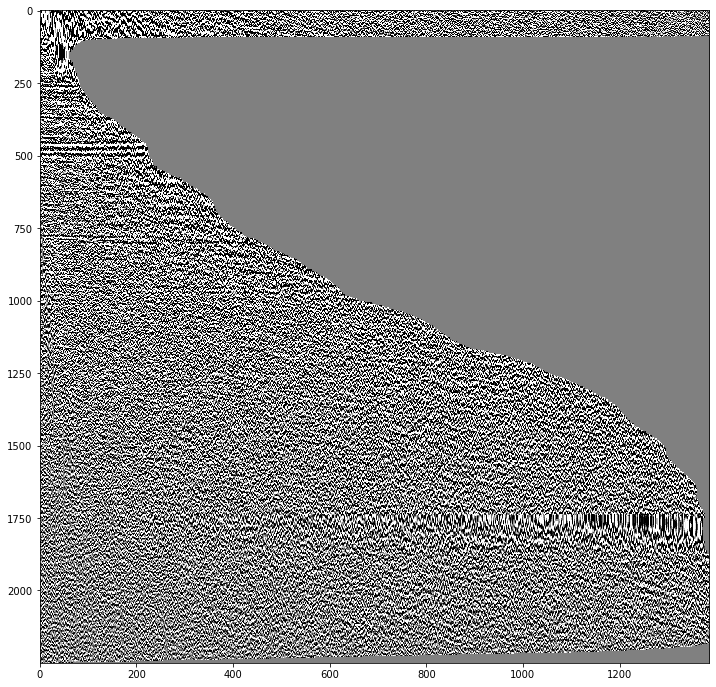

In [26]:
import matplotlib.pyplot as plt
_ = plt.figure(figsize=(12, 12))
field = batch.raw[0].T
dt = 0.002
times = times = np.arange(len(field)) * dt
offsets = np.sort(batch.index.get_df()['offset'].values)
plt.imshow(correct_seismogram(field, points, times, offsets, dt=dt), aspect='auto', cmap='gray', vmin=-10, vmax=10)

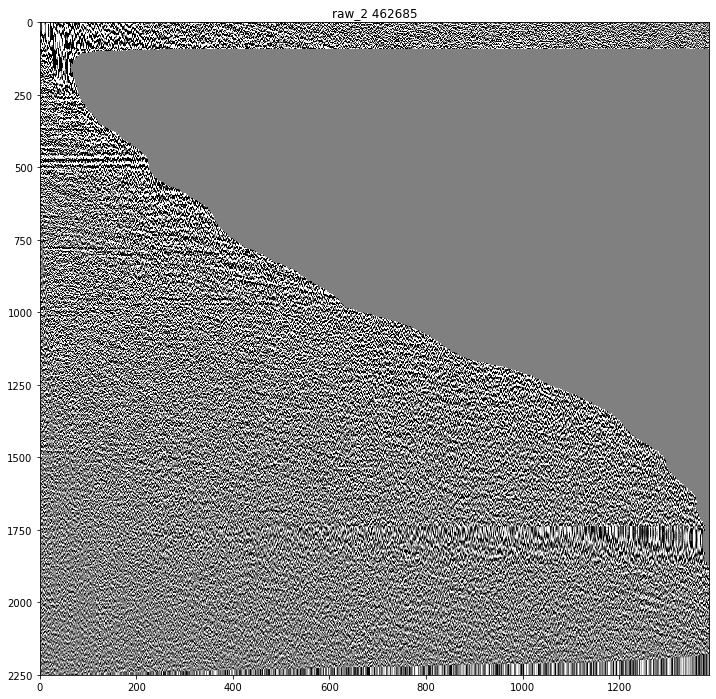

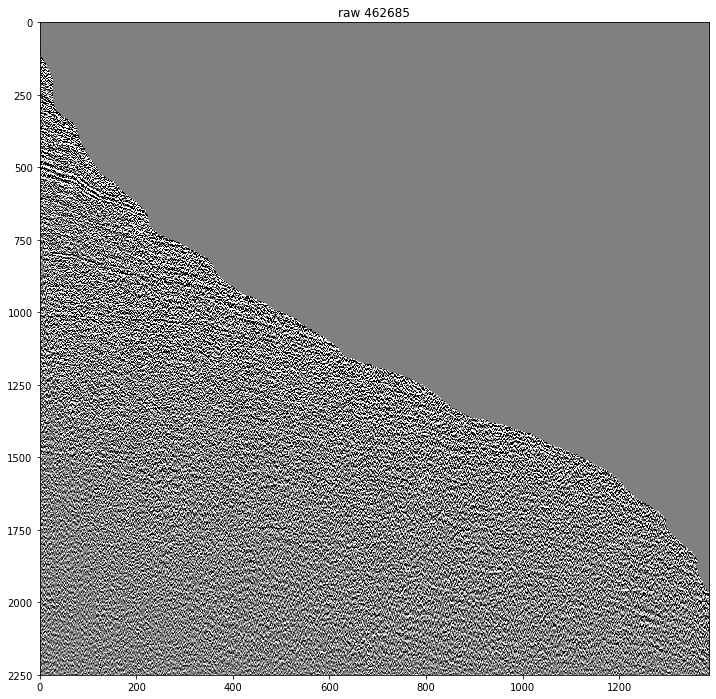

In [28]:
(batch
 .hodograph_straightening(velocities=batch.velocity_points[0], src='raw', dst='raw_2')
 .seismic_plot('raw_2', batch.index.indices[0], figsize=(12, 12), vmin=-cv, vmax=cv, cmap='gray')
 .seismic_plot('raw', batch.index.indices[0], figsize=(12, 12), vmin=-cv, vmax=cv, cmap='gray')
)

Metrics map for semblance

In [ ]:
cv = 0.1
pipeline = (picked_dataset.p
         .add_namespace(SemblanceMetrics)
         .init_variable('metrics')
         .load(fmt='segy', components='raw')
         .load(fmt='picks', components='markup')
         .sort_traces(src=('raw', 'markup'), dst=('raw', 'markup'), sort_by='offset')
         .add_muting(src='raw', dst='raw', picking='markup',
                     interpolation_type='regression', indent=300)
         .calculate_semblance(src='raw', dst='raw_semblance', velocities=[1300, 5500],
                              velocities_length=140, window=25)
         .calculate_minmax(B(), src='raw', dst='minmax_metrics')
         .get_coords_fm_supergather(src=['CDP_X', 'CDP_Y'], dst='coords')
         .gather_metrics(MetricsMap, metrics=B('minmax_metrics'),
                         coords=B('coords'),
                         save_to=V('metrics', mode='a'))
         .run_later(1, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

In [ ]:
pipeline.run()

In [ ]:
metrics_semblance = pipeline.v('metrics')
mean_metrics = metrics.evaluate('map', bin_size=40, figsize=(10, 7), save_dir=None, pad=True, max_value=0.5)
print('Mean value of metrics: {:.3}'.format(mean_metrics))